In [1]:
!pip install minigrid -q
!pip install "imitation>=1.0.0" -q
!pip install stable_baselines3 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.7/136.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 16.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.


In [2]:
!git clone https://github.com/Karen3264/imitation_learning

Cloning into 'imitation_learning'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (60/60), done.
Receiving objects: 100% (61/61), 24.72 KiB | 8.24 MiB/s, done.
Resolving deltas: 100% (29/29), done.
remote: Total 61 (delta 29), reused 0 (delta 0), pack-reused 0 (from 0)


# Github imports

In [3]:
import sys
sys.path.append("/content/imitation_learning")
from EmptyRandomGoal import RandomGoalEmptyEnv
from MazeEnv import MazeEnv
from Astar import find_optimal_action, AStarPolicy
from GridObsWrapper import GridObsWrapper
from CenterBlockEnv import CenterBlockEnv
from Plot import plot_k_trajectories

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Behaviour cloning

In [4]:
import numpy as np
import torch
from gymnasium.envs.registration import register
from gymnasium.wrappers import TransformReward
from minigrid.envs.empty import EmptyEnv
from minigrid.core.world_object import Goal
from minigrid.wrappers import ImgObsWrapper, FlatObsWrapper, FullyObsWrapper
from imitation.util.util import make_vec_env
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.data import rollout
from imitation.algorithms import bc
from imitation.policies.serialize import load_policy
from stable_baselines3.common.evaluation import evaluate_policy
from imitation.policies.serialize import policy_registry, load_policy
from imitation.algorithms import bc
from stable_baselines3.common.policies import ActorCriticPolicy, ActorCriticCnnPolicy
from stable_baselines3.common.logger import configure
import random



SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



custom_logger = configure(folder=None, format_strings=[])
register(id="Empty-Random-11x11-v0",entry_point=RandomGoalEmptyEnv, kwargs={"size": 11, "render_mode": "rgb_array", "agent_view_size": 5, "deterministic":True})
rng = np.random.default_rng(0)

def post(env, _seed):
    env = FullyObsWrapper(env)
    env = FlatObsWrapper(env)
    env = RolloutInfoWrapper(env)
    return env

print("generating A* rollouts")
env = make_vec_env("Empty-Random-11x11-v0", rng=rng, n_envs=1, post_wrappers=[post],)
policy = AStarPolicy(env.observation_space, env.action_space, env)
rollouts_list = rollout.rollout(policy, env, rollout.make_sample_until(min_timesteps=None, min_episodes=20), rng=rng)
transitions = rollout.flatten_trajectories(rollouts_list)

bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=transitions,
    rng=rng,
    custom_logger=custom_logger,)

bc_trainer.train(n_epochs=1000, progress_bar=False,log_rollouts_n_episodes=-1)
reward, _ = evaluate_policy(bc_trainer.policy, env, n_eval_episodes=10)
print("Reward:", reward)

generating A* rollouts


/usr/local/lib/python3.12/dist-packages/imitation/algorithms/bc.py:236: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  self._logger.record(f"bc/{k}", float(v) if v is not None else None)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Reward: 0.9683880000000002


In [5]:
from pprint import pprint

#pprint(vars(bc_trainer))
# 'loss_calculator': BehaviorCloningLossCalculator(ent_weight=0.001, l2_weight=0.0),

# Visualisation

In [6]:
import gymnasium as gym

class NoHighlightRender(gym.Wrapper):
    def render(self):
        return self.env.unwrapped.get_frame(highlight=False, tile_size=32)

env = RandomGoalEmptyEnv(size=11, render_mode="rgb_array", agent_view_size=3, deterministic=True)
env.action_space.seed(0)
env = FullyObsWrapper(env)
env = FlatObsWrapper(env)
env = NoHighlightRender(env)


Cloned policy


/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_pos to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_pos` for environment variables or `env.get_wrapper_attr('agent_pos')` that will search the reminding wrappers.
  logger.warn(
/content/imitation_learning/Plot.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(all_trajs))


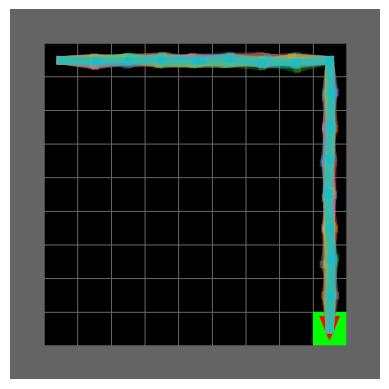

Noise policy


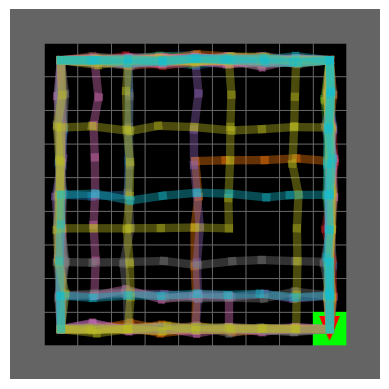

Optimal A* policy with noise


/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.envs` for environment variables or `env.get_wrapper_attr('envs')` that will search the reminding wrappers.
  logger.warn(


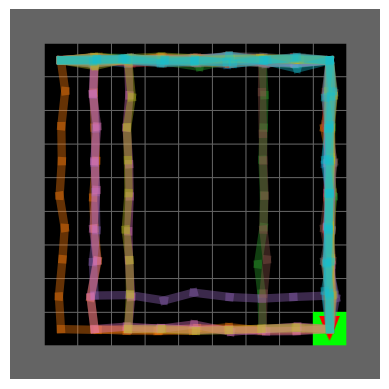

In [7]:
# env = RandomGoalEmptyEnv(size=11, render_mode="rgb_array", agent_view_size=3, deterministic=True)
# env.action_space.seed(0)
# env = FullyObsWrapper(env)
# env = FlatObsWrapper(env)
seeds = range(30)
print("Cloned policy")
plot_k_trajectories(env, seeds, policy=bc_trainer.policy)
print("Noise policy")
plot_k_trajectories(env, seeds, policy=bc_trainer.policy, noise=True)

print("Optimal A* policy with noise")
astarpolicy = AStarPolicy(env.observation_space, env.action_space, env)
plot_k_trajectories(env, seeds, policy=astarpolicy, noise=True)


# dAgger

In [8]:
%%capture
import tempfile
from imitation.algorithms.dagger import BetaSchedule
import math
import numpy as np
import gymnasium as gym
from stable_baselines3.common.evaluation import evaluate_policy
from imitation.algorithms import bc
from imitation.algorithms.dagger import SimpleDAggerTrainer
from imitation.policies.serialize import load_policy
from imitation.util.util import make_vec_env
from imitation.algorithms.dagger import LinearBetaSchedule, ExponentialBetaSchedule
from minigrid.wrappers import FullyObsWrapper

custom_logger = configure(folder=None, format_strings=[])
beta_schedule = LinearBetaSchedule(4)

register(
    id="Empty-Random-11x11-v0",
    entry_point=RandomGoalEmptyEnv,
    kwargs={"size": 11, "render_mode": "rgb_array", "agent_view_size": 5, "deterministic":True},
)

rng = np.random.default_rng(0)

def post(env, _seed):
    env = FullyObsWrapper(env)
    env = FlatObsWrapper(env)
    env = RolloutInfoWrapper(env)
    return env

env = make_vec_env("Empty-Random-11x11-v0", rng=rng, n_envs=1, post_wrappers=[post], )
policy = AStarPolicy(env.observation_space, env.action_space, env)

print("generating A* rollouts")
rollouts_list = rollout.rollout(
    policy,
    env,
    rollout.make_sample_until(min_timesteps=None, min_episodes=30),
    rng=rng,
)
print("training")
print(len(rollouts_list))

transitions = rollout.flatten_trajectories(rollouts_list)

bc_trainer_dagger = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=transitions,
    rng=rng,
)

with tempfile.TemporaryDirectory(prefix="dagger_example_") as tmpdir:
    print(tmpdir)
    dagger_trainer = SimpleDAggerTrainer(
        venv=env,
        scratch_dir=tmpdir,
        expert_policy=policy,
        bc_trainer=bc_trainer_dagger,
        rng=rng,
      beta_schedule=beta_schedule
    )
    print("train")


    dagger_trainer.train(8_000)

reward, _ = evaluate_policy(dagger_trainer.policy, env, n_eval_episodes=10)
print("Reward:", reward)

Cloned policy


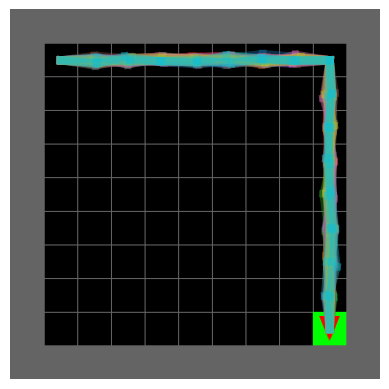

Noisy policy


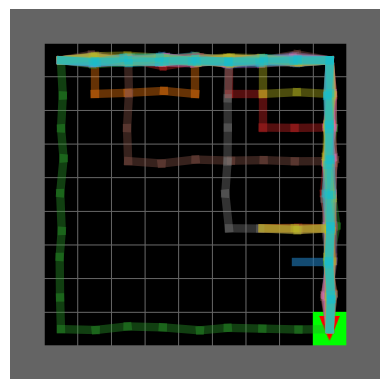

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import random


class NoHighlightRender(gym.Wrapper):
    def render(self):
        return self.env.unwrapped.get_frame(highlight=False, tile_size=32)

env = RandomGoalEmptyEnv(size=11, render_mode="rgb_array", agent_view_size=3, deterministic=True)
env=NoHighlightRender(env)


seeds = range(30)

print("Cloned policy")
env = RandomGoalEmptyEnv(size=11, render_mode="rgb_array", agent_view_size=5, deterministic=True)
env=NoHighlightRender(env)
env.action_space.seed(0)
env = FullyObsWrapper(env)
env = FlatObsWrapper(env)

plot_k_trajectories(env, seeds, policy=dagger_trainer.policy)

print("Noisy policy")
env = RandomGoalEmptyEnv(size=11, render_mode="rgb_array", agent_view_size=5, deterministic=True)
env=NoHighlightRender(env)
env.action_space.seed(0)
env = FullyObsWrapper(env)
env = FlatObsWrapper(env)
plot_k_trajectories(env, seeds, policy=dagger_trainer.policy, noise=True)